In [41]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
%matplotlib inline

In [109]:
# code for visualisation of each function
from graphviz import Digraph
def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for children in v._prev:
                edges.add((children, v))
                build(children)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': "BT"}) # LR = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n)) # Return the identity of an object. This is guaranteed to be unique among simultaneously existing objects. (CPython uses the object's memory address.)
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | gradient %.10f}" % (n.label, n.data, n.grad), 
                 shape='record',  style='filled', fillcolor='#F0F8FF')
        if n._op:
            # If this value is a result of some operations, create an _op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    dot.attr(label=r'Forward Pass')
    dot.attr(fontsize='12')
                 
    return dot

In [110]:
class Variable:
    def __init__(self, data, _children=(), _op = '', label = ''):
        """
        @ data: float  # input data
        @ _children: set, To keep track of all connections, basically to keep track of what variables are producing what Variables
        @ _op: str, To keep track of mathematical expression of each operation
        """
        
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # derivative of the value with respect to an _childern
        self._backward = lambda: None # this is responsible for the chain-rule value - a function that by default does nothing
        
    def __add__(self, other):
        """
        To add two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data + other.data, _children=(self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output

    def __sub__(self, other):
        """
        To subtract two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data - other.data, _children=(self, other), _op = '-')

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            
        output._backward = _backward
        return output
        
    def __mul__(self, other):
        """
        To multiply two Variable objects
        """
        other = other if isinstance(other, Variable) else Variable(other) 
        output = Variable(self.data * other.data, _children=(self, other), _op = '*')
        
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
            
        output._backward = _backward
        return output

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        output = Variable(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
            
        output._backward = _backward
        return output            
            

    def exp(self):
        x = self.data
        output = Variable(math.exp(x), _children=(self, ), _op='exp')

        def _backward():
            self.grad += output.grad * output.data
        output._backward = _backward
        return output
            

    def backward(self):
        topological_graph = []
        visited_nodes = set()
        
        def build_topological_graph(v):
            if v not in visited_nodes:
                visited_nodes.add(v)
                for child in v._prev:
                    build_topological_graph(child)
                topological_graph.append(v)
        
        build_topological_graph(self)

        self.grad = 1.0
        for node in reversed(topological_graph):
            node._backward()

    def __draw__(self):
        return draw_dot(self)
                
    def __repr__(self):
        """
        __repr__ is a built-in method in Python that returns a string representation of an object.
        """
        return f"Variable(data={self.data})"

    def __truediv__(self, other):
        """
        Return a / b where 2/3 is .66 rather than 0. This is also known as “true” division.
        """
        return self * other**-1

    def __neg__(self):
        """
        Return obj negated (-obj).
        """
        return self * -1

    def __rsub__(self, other):
        """
         __rsub__() method implements the reverse subtraction operation that is subtraction with reflected,
         swapped operands. # other - self
        """
        return other - self

    def __radd__(self, other): # other + self
        return self + other

    def __rtruediv__(self, other): # other / self
        """
        The Python __rtruediv__() method implements the reverse true division operation with reflected, 
        swapped operands. So, when you call other / self,
        """
        return other * self**-1

    def __rmul__(self, other):
        """
        Python can not multiply other * self if other is simply a digit. Ex: 2 * Variable(4)
        so we define __rmul__ which by default will run if __mul__ operation was not possible. 
        """
        return self * other


In [111]:
class Activations(Variable):
    def sigmoid(self):
        n = self.data
        t = 1/(1 + math.exp(-n))
        output = Variable(t, _children=(self, ), _op = 'sigmoid')

        def _backward():
            self.grad += t * (1 - t) * output.grad

        output._backward = _backward        
        return output

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        output = Variable(t, _children=(self, ), _op = 'tanh')

        def _backward():
            self.grad += (1 - t**2) * output.grad

        output._backward = _backward        
        return output

    def relu(self):
        """
        The product of gradients of ReLU function doesn't end up converging to 0 as the value is either 0 or 1.
        If the value is 1, the gradient is back propagated as it is. If it is 0, then no gradient is backpropagated from that point backwards.
        """
        n = self.data
        t = n if n > 0 else 0
        output = Variable(t, _children=(self, ), _op = 'relu')

        def _backward():
            if t > 0:
                self.grad += 1 * output.grad
            else:
                self.grad += 0 * output.grad

        output._backward = _backward        
        return output

    def leaky_relu(self):
        """
        """
        n = self.data
        t = n if n > 0 else 0.01*n
        output = Variable(t, _children=(self, ), _op = 'leaky relu')

        def _backward():
            if t > 0:
                self.grad += 1 * output.grad
            else:
                self.grad += 0.01 * output.grad

        output._backward = _backward        
        return output        

    # @staticmethod
    # def softmax(self, xs):
    #     datas = [x.data for x in xs]
    #     e_x = [np.exp(a - max(datas)) for a in [self.data] + datas]
    #     smx = e_x[0] / sum(e_x)
    #     output = Variable(smx, _children=(self, ), _op = 'softmax')

        # def _backward():
        #     if  > 0:
        #         self.grad += 1 * output.grad
        #     else:
        #         self.grad += 0.01 * output.grad
                
        # output._backward = _backward        
        # return output    

In [112]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def softmax_derivative(x):
    s = softmax(x)
    d = np.diag(s) - np.outer(s, s)
    return d

# Example usage:
x = np.array([1.0, 2.0, 3.0])
softmax_derivative_x = softmax_derivative(x)

print("Input x:", x)
print("Softmax derivative:", softmax_derivative_x)

Input x: [1. 2. 3.]
Softmax derivative: [[ 0.08192507 -0.02203304 -0.05989202]
 [-0.02203304  0.18483645 -0.1628034 ]
 [-0.05989202 -0.1628034   0.22269543]]


In [113]:
x1 = Variable(2., label = 'x1') # input 1 
x2 = Variable(0., label = 'x2') # input 2
w1 = Variable(-3., label = 'w1') # weight 1
w2 = Variable(1., label = 'w2') # weight 2
b = Variable(6.8813, label = 'b') # bias

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
sig1 = Activations.leaky_relu(x1w1x2w2); sig1.label = 'sig1'
sig2 = Activations.leaky_relu(x2w2); sig2.label = 'sig2'
n = sig1 + b; n.label = 'n' # raw input to a neuron without activation
o = Activations.tanh(n)

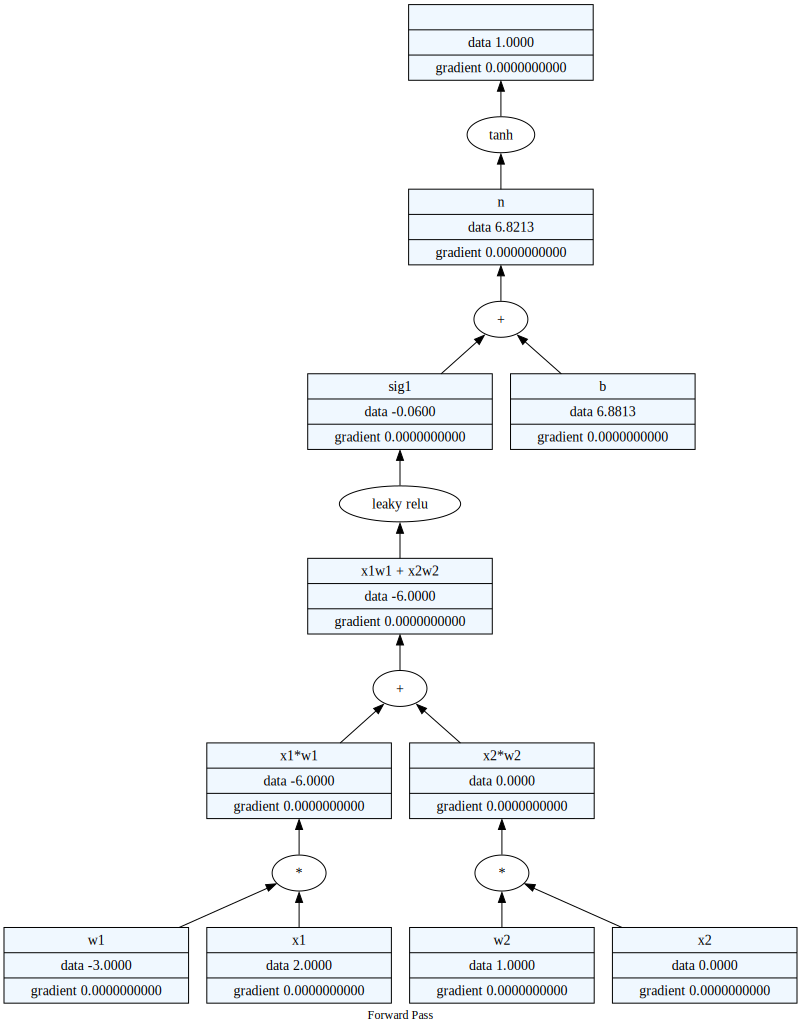

In [114]:
o.__draw__()

In [115]:
# act = getattr(Activations, 'tanh')

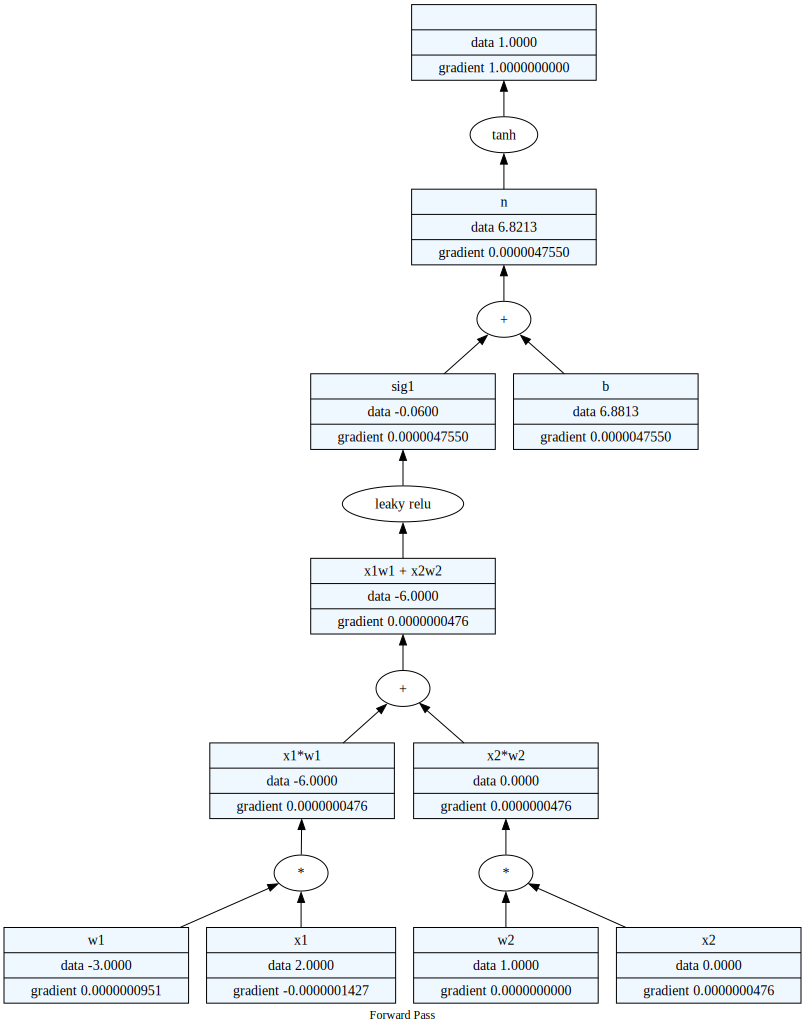

In [116]:
o.backward()
o.__draw__()

In [117]:
class Neuron:
    def __init__(self, input_d, activation = 'linear'):
        """
        @input_d: int, number of inputs to a given neuron
        """
        self.w = [Variable(random.uniform(-1, 1)) for _ in range(input_d)]
        self.b = Variable(random.uniform(-1, 1))
        self.activation = activation

    def __call__(self, x):
        """
        f(x) python will use __call__. 
        @x: list, input
        """
        act = sum((w_i*x_i for w_i, x_i in zip(self.w, x)), self.b)
        activation_function = getattr(Activations, self.activation)
        output = activation_function(act) if self.activation != 'linear' else act
        return output

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.activation} Neuron({len(self.w)})"

class Layer:
    def __init__(self, neuron_dim, layer_dim, activation = 'linear'):
        self.neurons = [Neuron(neuron_dim, activation) for _ in range(layer_dim)]
        
    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        params = [parameter for neuron in self.neurons for parameter in neuron.parameters()]
        return params

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:
    def __init__(self, input_dim, layers_dim, activation = 'linear'):
        sizes = [input_dim] + layers_dim
        self.layers = [Layer(sizes[i], sizes[i+1], activation=activation) for i in range(len(layers_dim))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]


    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

    def __draw__(self, x):
        return draw_dot(self.__call__(x))


In [118]:
# initialize a model 
model = MLP(2, [16, 16, 1], 'tanh') # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2)], Layer of [tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16)], Layer of [tanh Neuron(16)]]
number of parameters 337


In [119]:
X = [2, 3, -1]
model(X)

Variable(data=-0.9934858056659545)

In [120]:
# model.__draw__(x) # Too large

In [47]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Variable, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [Activations.relu(1 + -yi*scorei) for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

NameError: name 'y' is not defined

In [45]:
# optimization
for k in range(50):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.grad = 0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    
    # visualize decision boundary
    
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Variable, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

NameError: name 'X' is not defined